In [1]:
setwd("..")

In [2]:
source("Source/functions.R")

In [3]:
library("data.table")
library("Matrix")
library("Seurat")
library("clusterProfiler")
library("ggplot2")
library("ggsignif")
library("patchwork")
library("biomaRt")
library("reshape2")
library("pheatmap")
library("RColorBrewer")

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t


clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang,
W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize
multiomics data. Nature Protocols. 2024, doi:10.1038/s41596-024-01020-z

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter


Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt



In [4]:
pairwise_siggenes_exon <- Tools$read_xlsx(file = "Result/pairwise_siggenes_exon.xlsx", sheet = c("T_vs_S", "T_vs_M", "S_vs_M", "S_vs_N", "T_vs_N", "M_vs_N"))
pairwise_siggenes_exon <- lapply(pairwise_siggenes_exon, function(X) lapply(X, Tools$omit_space))

In [5]:
Spaethling2017_astro_cnts_dt <- fread("Data/Spaethling2017/cnts_exon_astro.csv.gz")
Spaethling2017_astro_metadata <- fread("Data/Spaethling2017/metadata_astro.csv")
Spaethling2017_astro_cnts <- Matrix(as.matrix(Spaethling2017_astro_cnts_dt[, -1]), dimnames = list(Spaethling2017_astro_cnts_dt[[1]], names(Spaethling2017_astro_cnts_dt)[-1]))
dim(Spaethling2017_astro_cnts)

[1] 23453   184

In [6]:
Spaethling2017_astro_srt <- CreateSeuratObject(Spaethling2017_astro_cnts, assay = "RNA", min.cells = 20, min.features = 200)
Spaethling2017_astro_srt <- Spaethling2017_astro_srt[, Spaethling2017_astro_srt$nCount_RNA >= 1e6]
dim(Spaethling2017_astro_srt)

[1] 14387   158

In [7]:
Spaethling2017_astro_srt <- NormalizeData(Spaethling2017_astro_srt, normalization.method = "LogNormalize", scale.factor = 1e6L)
Spaethling2017_astro_srt <- FindVariableFeatures(Spaethling2017_astro_srt, assay = "RNA", selection.method = "vst", nfeatures = 2000)
Spaethling2017_astro_srt <- ScaleData(Spaethling2017_astro_srt, vars.to.regress = "nFeature_RNA")

Normalizing layer: counts
Finding variable features for layer counts
Regressing out nFeature_RNA
Centering and scaling data matrix


In [8]:
Spaethling2017_astro_srt_meanvar <- HVFInfo(Spaethling2017_astro_srt)
Spaethling2017_astro_srt_allgenes <- rownames(Spaethling2017_astro_srt)
Spaethling2017_astro_srt_highvargenes <- VariableFeatures(Spaethling2017_astro_srt)

In [9]:
Spaethling2017_astro_srt_stdvar <- rbind(
    data.table(Class = "DE", Stdvar = Spaethling2017_astro_srt_meanvar[intersect(Spaethling2017_astro_srt_allgenes, pairwise_siggenes_exon[["T_vs_S"]][["both"]]), "variance.standardized"]), 
    data.table(Class = "nonDE", Stdvar = Spaethling2017_astro_srt_meanvar[setdiff(Spaethling2017_astro_srt_allgenes, pairwise_siggenes_exon[["T_vs_S"]][["both"]]), "variance.standardized"])
)

fig1 <- ggplot(Spaethling2017_astro_srt_stdvar, aes(x = Class, y = Stdvar)) + 
    geom_boxplot(outlier.size = 0.4) + 
    theme_classic(base_size = 12) + 
    geom_signif(test = "wilcox.test", test.args=list(alternative = "less"), comparisons = list(c("nonDE", "DE"))) + 
    xlab("") + 
    ylab("Standardized variance") + 
    ggtitle("Spaethling et al. 2017")

In [10]:
Spaethling2017_astro_srt <- RunPCA(Spaethling2017_astro_srt)

PC_ 1 
Positive:  Timp3, Mxra8, Fn1, Thbs1, Igfbp2, Igfbp3, Fgfr2, Arxes2, Fam178a, Mmp14 
	   9930013L23Rik, Crim1, Jam2, Nalcn, Adcy1, Prnp, Lrp4, Pxdn, Igfbp5, Slc22a23 
	   Arvcf, Ptprz1, Adamts5, Plod2, Hagh, Gpc6, Insr, Mest, Pgrmc1, Ncan 
Negative:  Lilrb4, Nckap1l, C3ar1, Itgam, Tyrobp, Ms4a7, Trem2, Csf1r, Ctss, Glipr1 
	   Clec4d, Milr1, Ccl3, Ms4a6d, Cybb, Emr1, Laptm5, Cd53, Myo1f, Fcrls 
	   Fcer1g, Mpeg1, Cd72, Fcgr3, Lyz2, Cx3cr1, Wfdc17, Gp49a, Arhgap30, Bcl2a1b 
PC_ 2 
Positive:  Tdrd7, Jhdm1d, Neat1, Sepp1, Ctsb, Plin2, Tmem87b, S1pr3, Rraga, Nckap1l 
	   Timp4, Fbxo32, Dock8, Shisa9, Zmym2, Tlr7, Myo1f, 5430435G22Rik, Rgp1, Bace2 
	   Cd14, Lrmp, Slc11a1, Ms4a7, Mfsd6, Slc2a13, Slc39a12, Zfp329, Zdhhc17, Fcgr3 
Negative:  Rad51, Shcbp1, Esco2, Mki67, Ube2c, Ncapg, Ckap2l, Neil3, Pbk, Dlgap5 
	   Nuf2, Top2a, 2810417H13Rik, Knstrn, Prc1, Kif18b, Rrm2, Kif11, Rad51ap1, Clspn 
	   Cdk1, Ccna2, Melk, Oip5, Kif15, Bub1, Cenpf, Ect2, Neurl1b, Cenpq 
PC_ 3 
Positive:  Clk1,

In [11]:
Spaethling2017_astro_srt <- FindNeighbors(Spaethling2017_astro_srt, dims = 1:15, annoy.metric = "cosine")

Computing nearest neighbor graph
Computing SNN


In [12]:
Spaethling2017_astro_srt <- FindClusters(Spaethling2017_astro_srt, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 158
Number of edges: 4213

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6465
Number of communities: 3
Elapsed time: 0 seconds


### Fig. 5B

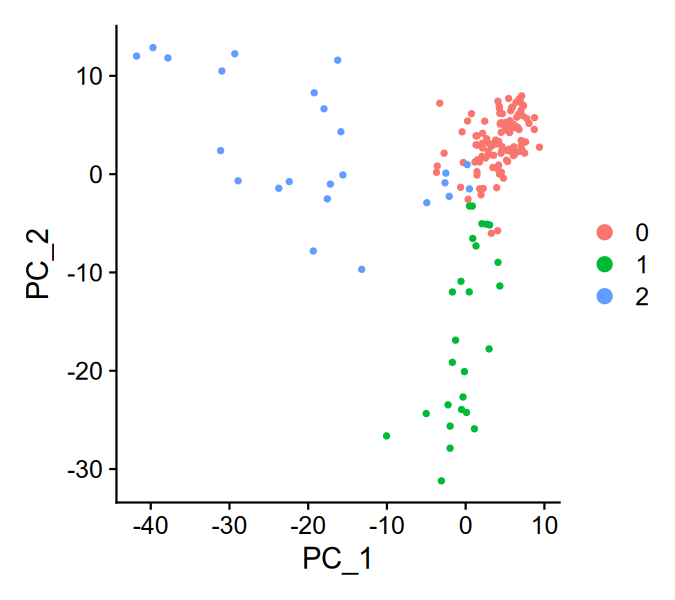

In [13]:
options(repr.plot.width = 4.5, repr.plot.height = 4, repr.plot.res = 150)
DimPlot(Spaethling2017_astro_srt, reduction = "pca", pt.size = 1)

In [14]:
Spaethling2017_astro_srt_DEuniqup <- FindAllMarkers(Spaethling2017_astro_srt, only.pos = TRUE, min.pct = 0.5, logfc.threshold = 0.5)
Spaethling2017_astro_srt_DEuniqup_siggenes <- tapply(Spaethling2017_astro_srt_DEuniqup$gene, Spaethling2017_astro_srt_DEuniqup$cluster, function(x) x)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2


In [15]:
fwrite(Spaethling2017_astro_srt_DEuniqup, file = "Result/Spaethling2017/astro_srt_DEuniqup_stats.csv")

In [16]:
Spaethling2017_astro_srt_DEuniqup_siggenes_df <- Tools$list_to_df(Spaethling2017_astro_srt_DEuniqup_siggenes)

In [17]:
fwrite(Spaethling2017_astro_srt_DEuniqup_siggenes_df, file = "Result/Spaethling2017/astro_srt_DEuniqup_siggenes.csv", row.names = FALSE)

In [18]:
contable <- sapply(pairwise_siggenes_exon[["T_vs_S"]][c("up", "dn")], function(x) sapply(Spaethling2017_astro_srt_DEuniqup_siggenes, function(y) length(intersect(x, y))))
contable                                                                                         

,up,dn
0,4,14
1,5,47
2,14,16


In [19]:
fisher.test(contable[-1, ])


	Fisher's Exact Test for Count Data

data:  contable[-1, ]
p-value = 0.0002535
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.03029032 0.43934358
sample estimates:
odds ratio 
 0.1253895 


### Fig. 5B (table inset, left)

In [20]:
print(sort(intersect(pairwise_siggenes_exon[["T_vs_S"]][["up"]], Spaethling2017_astro_srt_DEuniqup_siggenes[["2"]])))

 [1] "AI607873" "Cotl1"    "Laptm5"   "Ly86"     "Mir703"   "Mpeg1"   
 [7] "Rnase4"   "Rpl13a"   "Rpl35a"   "Rpl36al"  "Rps20"    "Taldo1"  
[13] "Tmsb4x"   "Zfp239"  


### Fig. 5B (table inset, right)

In [21]:
print(sort(intersect(pairwise_siggenes_exon[["T_vs_S"]][["dn"]], Spaethling2017_astro_srt_DEuniqup_siggenes[["1"]])))

 [1] "2610002M06Rik" "4930579G24Rik" "Ankrd32"       "Arhgap22"     
 [5] "Aspm"          "Atm"           "Bard1"         "Brd8"         
 [9] "C530008M17Rik" "Cdc20"         "Cdc25b"        "Cdc25c"       
[13] "Cdca8"         "Cenpe"         "Cenpf"         "Fam64a"       
[17] "Fam72a"        "Fanci"         "Gas2l3"        "Iqgap3"       
[21] "Kif11"         "Kif15"         "Kif20b"        "Kif23"        
[25] "Knstrn"        "L3mbtl2"       "Mdc1"          "Mki67"        
[29] "Ncapg"         "Nek2"          "Neurl1b"       "Nrarp"        
[33] "Nsl1"          "Parpbp"        "Piga"          "Plk1"         
[37] "Ppwd1"         "Prr11"         "Rps6ka6"       "Sdc1"         
[41] "Sgol2"         "Ska3"          "Stag3"         "Tex30"        
[45] "Top2a"         "Usp37"         "Whsc1"        


### Fig. 5C (top)

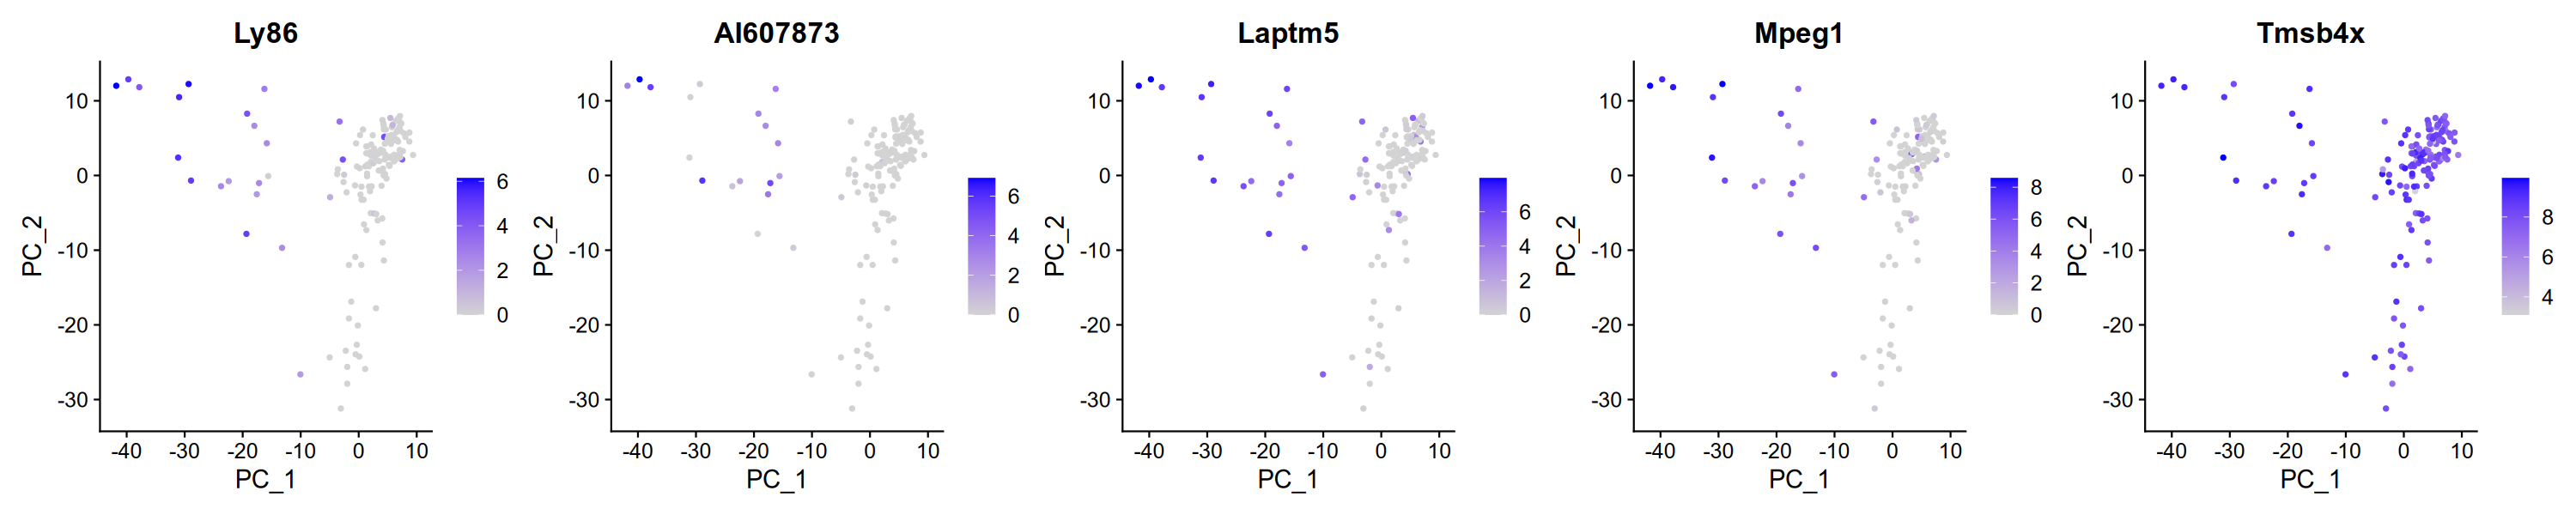

In [22]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
FeaturePlot(Spaethling2017_astro_srt, 
    features = with(
        Spaethling2017_astro_srt_DEuniqup[
            Reduce(
                intersect, 
                c(list(
                    pairwise_siggenes_exon[["T_vs_S"]][["up"]]), 
                    Spaethling2017_astro_srt_DEuniqup_siggenes["2"]
                 )
            ), 
        ], 
        head(gene[order(p_val)], 5)
    ), 
    reduction = "pca", 
    ncol = 5, 
    cols = c("lightgrey", "blue")
)

### Fig. 5C (bottom)

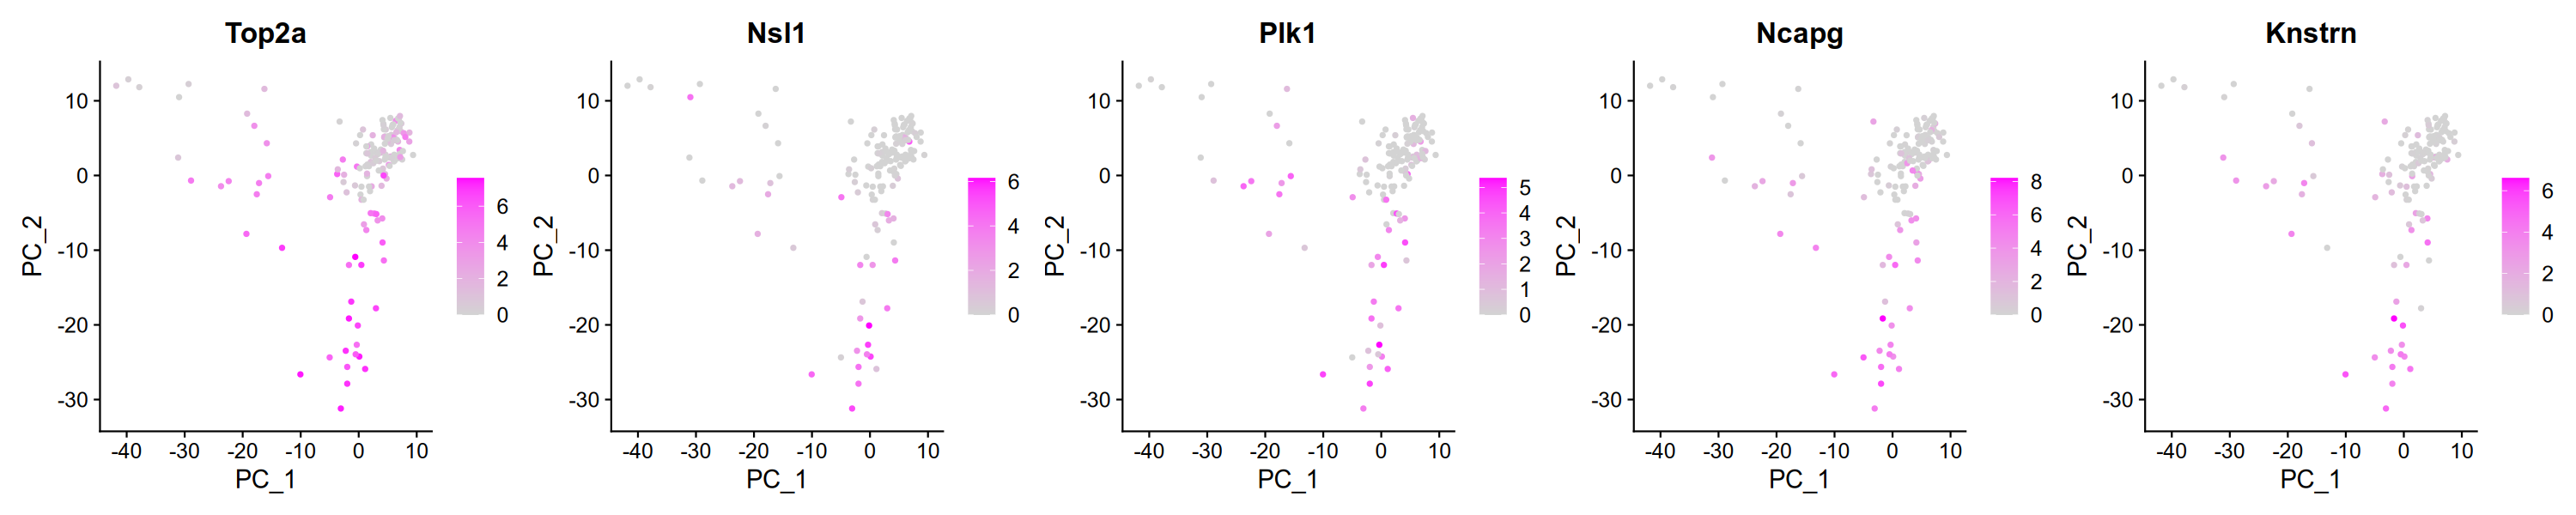

In [23]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
FeaturePlot(Spaethling2017_astro_srt, 
    features = with(
        Spaethling2017_astro_srt_DEuniqup[
            Reduce(
                intersect, 
                c(list(
                    pairwise_siggenes_exon[["T_vs_S"]][["dn"]]), 
                    Spaethling2017_astro_srt_DEuniqup_siggenes["1"]
                )
            ), 
        ], 
        head(gene[order(p_val)], 5)
    ), 
    reduction = "pca", 
    ncol = 5, 
    cols = c("lightgrey", "magenta")
)

In [24]:
GOSymbolList <- readRDS(file = "Data/GO/OrgDb/GOSymbol.2019.RDS")
GOSymbol <- GOSymbolList$mouse
GONameList <- readRDS(file = "Data/GO/OrgDb/GOName.2019.RDS")
GOName <- GONameList$mouse

In [25]:
Spaethling2017_astro_srt_DEuniqup_ego <- NULL
for (x in c("0", "1", "2")) {
    for (z in c("MF", "BP", "CC")) {
        message(x, " ", z)
        Spaethling2017_astro_srt_DEuniqup_ego[[x]][[z]] <- NULL
        e <- enricher(
            gene = Spaethling2017_astro_srt_DEuniqup_siggenes[[x]], 
            pvalueCutoff = Inf, 
            qvalueCutoff = Inf, 
            universe = Spaethling2017_astro_srt_allgenes, 
            pAdjustMethod = "BH", 
            minGSSize = 10, 
            maxGSSize = 500, 
            TERM2GENE = GOSymbol[[z]], 
            TERM2NAME = GOName[[z]]
        )
        Spaethling2017_astro_srt_DEuniqup_ego[[x]][[z]] <- NULL
        Spaethling2017_astro_srt_DEuniqup_ego[[x]][[z]] <- as.data.table(e)
    }
}

0 MF
0 BP
0 CC
1 MF
1 BP
1 CC
2 MF
2 BP
2 CC


In [26]:
Spaethling2017_astro_srt_DEuniqup_ego_dfs <- NULL
for (x in c("0", "1", "2")) {
    Y <- rbindlist(lapply(c("MF", "BP", "CC"), function(o) {
        X <- Spaethling2017_astro_srt_DEuniqup_ego[[x]][[o]]
        X[, Category := o]
        X
    }))
    Y <- Y[order(Y$p.adjust), ]
    Spaethling2017_astro_srt_DEuniqup_ego_dfs[[x]] <- NULL
    Spaethling2017_astro_srt_DEuniqup_ego_dfs[[x]] <- Y
}

In [27]:
filename <- "Result/Spaethling2017/astro_srt_DEuniqup_enrich_GO.xlsx"
Tools$write_xlsx(Spaethling2017_astro_srt_DEuniqup_ego_dfs, file = filename, row.names = FALSE)

### Fig. 5D (top)

In [28]:
Spaethling2017_astro_srt_DEuniqup_ego_dfs[["0"]][Category == "BP", c("ID", "Description", "Count", "p.adjust")][1:10]

ID,Description,Count,p.adjust
<chr>,<chr>,<int>,<dbl>
GO:0007528,neuromuscular junction development,8,0.0001665043
GO:0030198,extracellular matrix organization,13,0.0001665043
GO:0048514,blood vessel morphogenesis,7,0.0003443152
GO:0007155,cell adhesion,24,0.0003443152
GO:0001525,angiogenesis,16,0.0004154613
GO:0051897,positive regulation of protein kinase B signaling,10,0.0004154613
GO:0048813,dendrite morphogenesis,8,0.0005566212
GO:0030335,positive regulation of cell migration,15,0.0016625009
GO:0001934,positive regulation of protein phosphorylation,13,0.0029113414


### Fig. 5D (middle)

In [29]:
Spaethling2017_astro_srt_DEuniqup_ego_dfs[["1"]][Category == "BP", c("ID", "Description", "Count", "p.adjust")][1:10]

ID,Description,Count,p.adjust
<chr>,<chr>,<int>,<dbl>
GO:0051301,cell division,111,1.466989e-68
GO:0006260,DNA replication,52,3.259758e-38
GO:0007059,chromosome segregation,37,7.463241e-29
GO:0006974,cellular response to DNA damage stimulus,77,1.208715e-27
GO:0006281,DNA repair,65,2.577626e-26
GO:0000278,mitotic cell cycle,41,3.760871e-26
GO:0000070,mitotic sister chromatid segregation,19,7.201995e-19
GO:0006270,DNA replication initiation,17,1.938614e-17
GO:0000724,double-strand break repair via homologous recombination,22,4.986804e-13


### Fig. 5D (bottom)

In [30]:
Spaethling2017_astro_srt_DEuniqup_ego_dfs[["2"]][Category == "BP", c("ID", "Description", "Count", "p.adjust")][1:10]

ID,Description,Count,p.adjust
<chr>,<chr>,<int>,<dbl>
GO:0002376,immune system process,57,9.439775e-24
GO:0045087,innate immune response,45,2.294180e-18
GO:0006954,inflammatory response,37,5.730507e-15
GO:0006955,immune response,24,4.277733e-11
GO:0009617,response to bacterium,25,2.580909e-10
GO:0042742,defense response to bacterium,17,2.619135e-10
GO:0006935,chemotaxis,19,5.090441e-10
GO:0006909,phagocytosis,16,6.247726e-10
GO:0030593,neutrophil chemotaxis,14,3.586951e-09


In [31]:
Batiuk2020_cnts_dt <- fread("Data/Batiuk2020/GSE114000_cnts.csv.gz")
Batiuk2020_metadata <- fread("Data/Batiuk2020/GSE114000_metadata.csv")
Batiuk2020_cnts <- Matrix(as.matrix(Batiuk2020_cnts_dt[, -1]), dimnames = list(Batiuk2020_cnts_dt[[1]], names(Batiuk2020_cnts_dt)[-1]))
dim(Batiuk2020_cnts)

[1] 49660  2031

In [32]:
table(Batiuk2020_metadata$Type)


          (none)             AST1             AST2             AST3 
              16              661              573              460 
            AST4             AST5      Endothelial       Microglial 
              91               26               30               11 
           Mural         Neuronal Oligodendrocytic 
             137               17                9 

In [33]:
Batiuk2020_astro_cnts <- Batiuk2020_cnts[, Batiuk2020_metadata[grepl("^AST", Type), `Cell ID`]]
dim(Batiuk2020_astro_cnts)

[1] 49660  1811

In [34]:
Batiuk2020_astro_srt <- CreateSeuratObject(Batiuk2020_astro_cnts, assay = "RNA", min.cells = 20, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [35]:
Batiuk2020_astro_srt <- NormalizeData(Batiuk2020_astro_srt, normalization.method = "LogNormalize", scale.factor = 1e6L)
Batiuk2020_astro_srt <- FindVariableFeatures(Batiuk2020_astro_srt, assay = "RNA", selection.method = "vst", nfeatures = 2000)

Normalizing layer: counts
Finding variable features for layer counts


In [36]:
Batiuk2020_astro_srt_meanvar <- HVFInfo(Batiuk2020_astro_srt)
Batiuk2020_astro_srt_allgenes <- rownames(Batiuk2020_astro_srt)
Batiuk2020_astro_srt_highvargenes <- VariableFeatures(Batiuk2020_astro_srt)

In [37]:
Batiuk2020_astro_srt_stdvar <- rbind(
    data.table(Class = "DE", Stdvar = Batiuk2020_astro_srt_meanvar[intersect(Batiuk2020_astro_srt_allgenes, pairwise_siggenes_exon[["T_vs_S"]][["both"]]), "variance.standardized"]), 
    data.table(Class = "nonDE", Stdvar = Batiuk2020_astro_srt_meanvar[setdiff(Batiuk2020_astro_srt_allgenes, pairwise_siggenes_exon[["T_vs_S"]][["both"]]), "variance.standardized"])
)

fig2 <- ggplot(Batiuk2020_astro_srt_stdvar, aes(x = Class, y = Stdvar)) + 
    geom_boxplot(outlier.size = 0.4) + 
    theme_classic(base_size = 12) + 
    geom_signif(test = "wilcox.test", test.args=list(alternative = "less"), comparisons = list(c("nonDE", "DE"))) + 
    xlab("") + 
    ylab("Standardized variance") +
    ggtitle("Batiuk et al. 2020")

In [38]:
## Use the original publication's subtypes
Idents(Batiuk2020_astro_srt) <- Batiuk2020_metadata[J(colnames(Batiuk2020_astro_srt)), on = "Cell ID"][, factor(Type)]

In [39]:
Idents(Batiuk2020_astro_srt) |> table()


AST1 AST2 AST3 AST4 AST5 
 661  573  460   91   26 

In [40]:
## Use the original publication's subtype specific markers
Batiuk2020_astro_srt_DEuniqup_siggenes_df <- Tools$read_xlsx("Data/Batiuk2020/SuppData2.xlsx", sheet = "AstroSeuratMarkers")[[1]]

In [41]:
colnames(Batiuk2020_astro_srt_DEuniqup_siggenes_df) <- Batiuk2020_astro_srt_DEuniqup_siggenes_df[1, ]
Batiuk2020_astro_srt_DEuniqup_siggenes_df <- Batiuk2020_astro_srt_DEuniqup_siggenes_df[-1, ]
Batiuk2020_astro_srt_DEuniqup_siggenes <- with(Batiuk2020_astro_srt_DEuniqup_siggenes_df, tapply(`Marker gene`, Cluster, function(x) x))

In [42]:
str(Batiuk2020_astro_srt_DEuniqup_siggenes)

List of 5
 $ AST1: chr [1:37] "Hsd11b1" "Gfap" "Fam213a" "Agt" ...
 $ AST2: chr [1:126] "Slc7a10" "F3" "Msmo1" "Kcnk1" ...
 $ AST3: chr [1:36] "Luzp2" "Hes5" "Dhrs3" "Fos" ...
 $ AST4: chr [1:460] "Frzb" "Dbi" "Cd9" "Notch2" ...
 $ AST5: chr [1:217] "Cox8a" "Fth1" "Fam107a" "Selenow" ...
 - attr(*, "dim")= int 5
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:5] "AST1" "AST2" "AST3" "AST4" ...


In [43]:
## We then ask whether T vs. S DEGs show any enrichment in Batiuk et al. 2020 astrocyte subtypes.
Batiuk2020_astro_srt_DEuniqup_siggenes_symbol <- rbindlist(lapply(names(Batiuk2020_astro_srt_DEuniqup_siggenes), function(x) data.table(Subtype = x, Symbol = Batiuk2020_astro_srt_DEuniqup_siggenes[[x]])))
Batiuk2020_astro_srt_DEuniqup_siggenes_desc <- rbindlist(lapply(names(Batiuk2020_astro_srt_DEuniqup_siggenes), function(x) data.table(Subtype = x, Desc = x)))

In [44]:
pairwise_cmps <- c("T_vs_S", "T_vs_M", "S_vs_M", "S_vs_N", "T_vs_N", "M_vs_N")
pairwise_DE_tables_exon <- Tools$read_xlsx(file = "Result/pairwise_DE_tables_exon.xlsx", sheet = pairwise_cmps)
pairwise_exon_gsea_Batiuk2020 <- NULL
for (x in pairwise_cmps) {
    pairwise_exon_gsea_Batiuk2020[[x]] <- NULL
    message(x)
    X <- pairwise_DE_tables_exon[[x]]
    X <- X[order(X[, "stat"], decreasing = TRUE), ]
    stats <- structure(X[, "stat"], names = X[, "Symbol"])
    e <- GSEA(
        geneList = stats, 
        exponent = 1, 
        pvalueCutoff = Inf, 
        pAdjustMethod = "BH", 
        TERM2GENE = Batiuk2020_astro_srt_DEuniqup_siggenes_symbol, 
        TERM2NAME = Batiuk2020_astro_srt_DEuniqup_siggenes_desc
    )
    pairwise_exon_gsea_Batiuk2020[[x]] <- NULL
    pairwise_exon_gsea_Batiuk2020[[x]] <- as.data.table(e)
}

T_vs_S
using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).

preparing geneSet collections...
GSEA analysis...
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.09% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...
done...
T_vs_M
using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).

preparing geneSet collections...
GSEA analysis...
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...
done...
S_vs_

In [45]:
Tools$write_xlsx(pairwise_exon_gsea_Batiuk2020, file= "Result/Batiuk2020/pairwise_exon_gsea_Batiuk2020.xlsx", row.names = FALSE)

In [46]:
pairwise_DE_tables_exon_T_vs_S <- pairwise_DE_tables_exon[["T_vs_S"]]
pairwise_DE_tables_exon_T_vs_S <- pairwise_DE_tables_exon_T_vs_S[order(pairwise_DE_tables_exon_T_vs_S[, "stat"], decreasing = TRUE), ]
pairwise_DE_stats_exon_T_vs_S <- with(pairwise_DE_tables_exon_T_vs_S, structure(stat, names = Symbol))
pairwise_DE_gsea_exon_T_vs_S_Batiuk2020 <- GSEAJava$getRunSums(
    pairwise_DE_stats_exon_T_vs_S, 
    genesets = Batiuk2020_astro_srt_DEuniqup_siggenes
)

### Fig. 5E

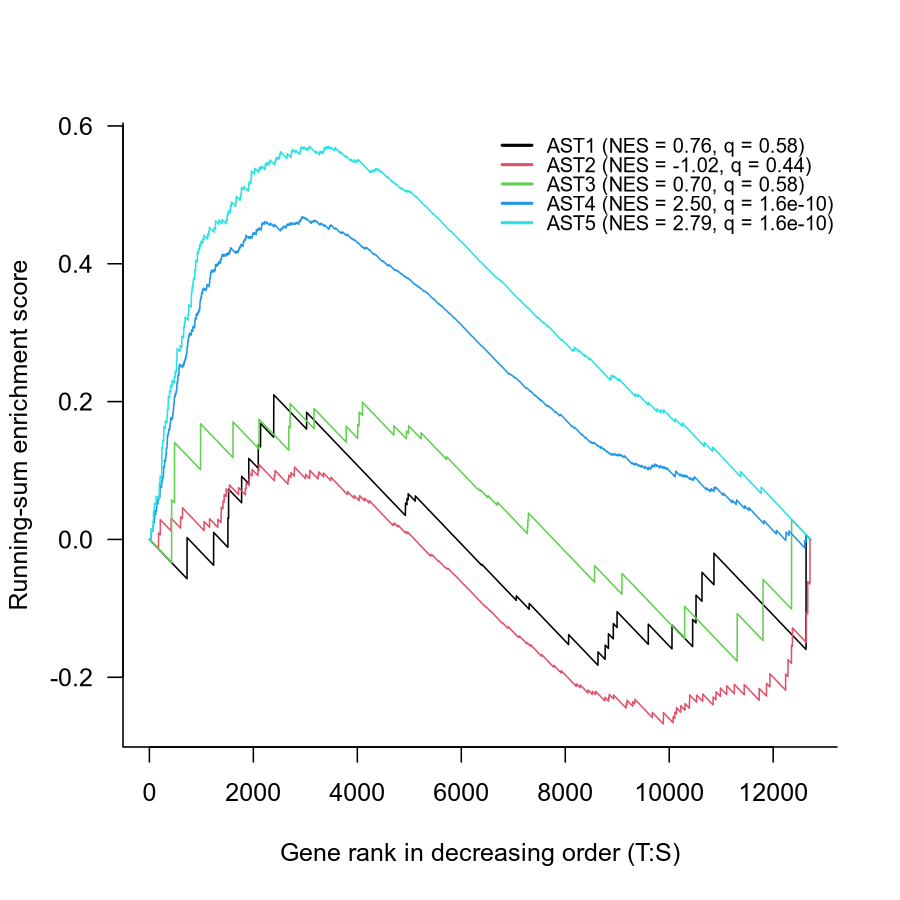

In [47]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
matplot(pairwise_DE_gsea_exon_T_vs_S_Batiuk2020, 
    type = "l", 
    lty = 1, 
    xlab = "Gene rank in decreasing order (T:S)", 
    ylab = "Running-sum enrichment score", 
    las = 1, 
    bty = "L"
)
k <- names(Batiuk2020_astro_srt_DEuniqup_siggenes)
X <- pairwise_exon_gsea_Batiuk2020[["T_vs_S"]]
legend(6500, 0.6, 
    legend = paste0(k, 
        " (NES = ", 
        sprintf("%.2f", X[J(k), on = "ID"][, NES]), 
        ", q = ", 
        sprintf("%.2g", X[J(k), on = "ID"][, qvalue]), 
        ")"
    ), 
    col = 1:5, 
    lty = 1, 
    lwd = 2, 
    box.col = NA, 
    cex = 0.8
)

In [48]:
Vanlandewijck2018_astro_cnts_dt <- fread("Data/Vanlandewijck2018/GSE99058_cnts.csv.gz")
Vanlandewijck2018_astro_metadata <- fread("Data/Vanlandewijck2018/GSE99058_metadata.csv")
Vanlandewijck2018_astro_cnts <- Matrix(
    as.matrix(Vanlandewijck2018_astro_cnts_dt[, -1]), 
    dimnames = list(Vanlandewijck2018_astro_cnts_dt[[1]], names(Vanlandewijck2018_astro_cnts_dt)[-1]))
dim(Vanlandewijck2018_astro_cnts)

[1] 24490   250

In [49]:
Vanlandewijck2018_astro_srt <- CreateSeuratObject(Vanlandewijck2018_astro_cnts, assay = "RNA", min.cells = 20, min.features = 200)

In [50]:
Vanlandewijck2018_astro_srt <- NormalizeData(Vanlandewijck2018_astro_srt, normalization.method = "LogNormalize", scale.factor = 1e6L)
Vanlandewijck2018_astro_srt <- FindVariableFeatures(Vanlandewijck2018_astro_srt, assay = "RNA", selection.method = "vst", nfeatures = 2000)

Normalizing layer: counts
Finding variable features for layer counts


In [51]:
Vanlandewijck2018_astro_srt_meanvar <- HVFInfo(Vanlandewijck2018_astro_srt)
Vanlandewijck2018_astro_srt_allgenes <- rownames(Vanlandewijck2018_astro_srt)
Vanlandewijck2018_astro_srt_highvargenes <- VariableFeatures(Vanlandewijck2018_astro_srt)

In [52]:
Vanlandewijck2018_astro_srt_stdvar <- rbind(
    data.table(Class = "DE", Stdvar = Vanlandewijck2018_astro_srt_meanvar[intersect(Vanlandewijck2018_astro_srt_allgenes, pairwise_siggenes_exon[["T_vs_S"]][["both"]]), "variance.standardized"]), 
    data.table(Class = "nonDE", Stdvar = Vanlandewijck2018_astro_srt_meanvar[setdiff(Vanlandewijck2018_astro_srt_allgenes, pairwise_siggenes_exon[["T_vs_S"]][["both"]]), "variance.standardized"])
)

fig3 <- ggplot(Vanlandewijck2018_astro_srt_stdvar, aes(x = Class, y = Stdvar)) + 
    geom_boxplot(outlier.size = 0.4) + 
    theme_classic(base_size = 12) + 
    geom_signif(test = "wilcox.test", test.args=list(alternative = "less"), comparisons = list(c("nonDE", "DE"))) + 
    xlab("") + 
    ylab("Standardized variance") + 
    ggtitle("Vanlandewijck et al. 2018")

### Fig. 5A

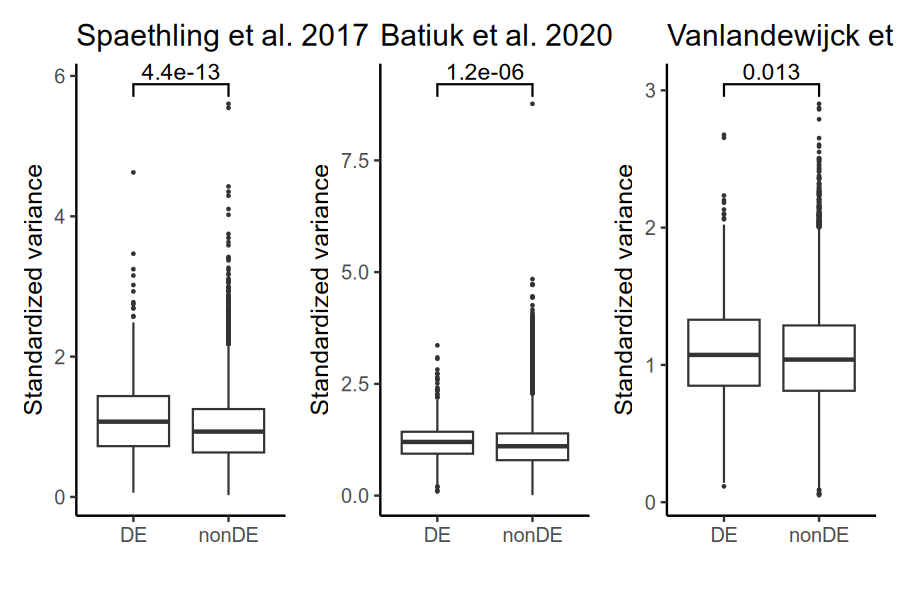

In [53]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 150)
fig1 + fig2 + fig3

In [54]:
Kapoor2019_supp_siggenes <- Tools$read_xlsx("Data/Kapoor2019/SuppTable1.xlsx", sheet = "Tab1")[[1]]

In [55]:
mart_human = useMart("ensembl", dataset = "hsapiens_gene_ensembl", host = "https://dec2021.archive.ensembl.org")
mart_mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://dec2021.archive.ensembl.org")

In [56]:
human_mouse_map <- getLDS(
    attributes = c("hgnc_symbol"), 
    filters = "hgnc_symbol", 
    values = Kapoor2019_supp_siggenes$Gene, 
    mart = mart_human, 
    attributesL = c("mgi_symbol"), 
    martL = mart_mouse
)

In [57]:
head(human_mouse_map)

,HGNC.symbol,MGI.symbol
,<chr>,<chr>
1,MYOZ3,Myoz3
2,TRIB2,Trib2
3,INO80C,Ino80c
4,ZNF185,Zfp185
5,GABRE,Gabre
6,LONRF3,Lonrf3


In [58]:
fwrite(human_mouse_map, file = "Result/Kapoor2019/human_mouse_map.csv")

In [59]:
human_to_mouse <- with(human_mouse_map, tapply(MGI.symbol, HGNC.symbol, function(x) unique(x[!is.na(x) & x != ""])))
Kapoor2019_supp_siggenes_byclust <- with(Kapoor2019_supp_siggenes, tapply(Gene, Module.Color, function(x) x))
Kapoor2019_supp_siggenes_byclust <- lapply(Kapoor2019_supp_siggenes_byclust, function(x) unique(unlist(human_to_mouse[x])))

Kapoor2019_supp_siggenes_subset <- Kapoor2019_supp_siggenes_byclust[lengths(Kapoor2019_supp_siggenes_byclust) > 20]
Kapoor2019_supp_siggenes_subset <- reshape2::melt(Kapoor2019_supp_siggenes_subset)

Kapoor2019_supp_siggenes_subset <- Kapoor2019_supp_siggenes_subset[, 2:1]
colnames(Kapoor2019_supp_siggenes_subset) <- c("Subtype", "Symbol")

setDT(Kapoor2019_supp_siggenes_subset)

In [60]:
Kapoor2019_supp_siggenes_subset_name <- data.table(Subtype = Kapoor2019_supp_siggenes_subset$Subtype, Desc = Kapoor2019_supp_siggenes_subset$Subtype)

In [61]:
pairwise_exon_ego_Kapoor2019 <- NULL
for (x in pairwise_cmps) {
    e <- enricher(
        gene = pairwise_siggenes_exon[[x]]$both, 
        universe = pairwise_DE_tables_exon[[x]][, "Symbol"],
        TERM2GENE = Kapoor2019_supp_siggenes_subset, 
        TERM2NAME = Kapoor2019_supp_siggenes_subset_name, 
        pvalueCutoff = Inf, 
        qvalueCutoff = Inf
    )
    pairwise_exon_ego_Kapoor2019[[x]] <- NULL
    pairwise_exon_ego_Kapoor2019[[x]] <- as.data.table(e)
}

In [62]:
Tools$write_xlsx(pairwise_exon_ego_Kapoor2019, file = "Result/Kapoor2019/pairwise_exon_ego_Kapoor2019.xlsx", row.names = FALSE)

In [63]:
clusters <- names(Kapoor2019_supp_siggenes_byclust)[lengths(Kapoor2019_supp_siggenes_byclust) > 20]
clusters <- clusters[c(10, 4, 1:3, 5:9, 11)]
clusters

[1] "thistle2"        "brown4"          "black"           "blue"           
 [5] "brown"           "darkolivegreen"  "grey60"          "lightcyan"      
 [9] "lightsteelblue1" "paleturquoise"   "yellow"

In [64]:
pairwise_exon_ego_pval_Kapoor2019 <- sapply(c("T_vs_N", "S_vs_N", "T_vs_S"), function(x) pairwise_exon_ego_Kapoor2019[[x]][J(clusters), pvalue, on = "ID"])
rownames(pairwise_exon_ego_pval_Kapoor2019) <- clusters

### Fig. 5F

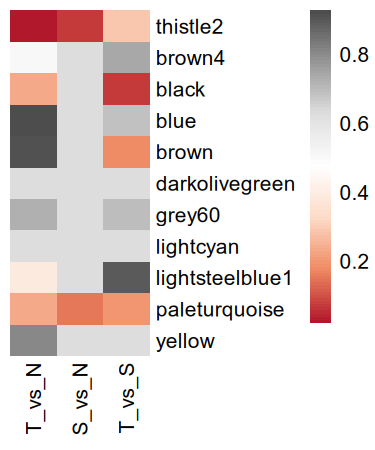

In [65]:
options(repr.plot.width = 2.5, repr.plot.height = 3, repr.plot.res = 150)
pheatmap(pairwise_exon_ego_pval_Kapoor2019, cluster_row = FALSE, cluster_col = FALSE, border_col = NA, angle = 90, colorRampPalette((brewer.pal(n = 7, name = "RdGy")))(100))

In [66]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3     pheatmap_1.0.12        reshape2_1.4.4        
 [4] biomaRt_2.60.1         patchwork_1.3.0        ggsignif_0.6.4        
 [7] ggplot2_3.5.1        